In [1]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(RColorBrewer)
library(ggtree)
library(ape)
library(cowplot)
library(grid)
library(extrafont)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.t

In [2]:
theme_set(theme_classic() + theme(text = element_text(size=20, family = "Arial")))
options(StringsAsFactors=FALSE)
clade_colors <- c("#E64B35FF","#4DBBD5FF","#00A087FF")


# Fig5a Phylogeny of L2 lineage

In [3]:
## Read in tree 
filename <- "../data/Peru_255_ML.tre"
L2tree <- ape::read.nexus(filename)
#L2tree
p <- ggtree(L2tree)

# determing clade to manipulate for visualization
edge <- data.frame(L2tree$edge, edge_num=1:nrow(L2tree$edge))
colnames(edge) <- c("parent", "node", "edge_num")


In [6]:
options(repr.plot.width=9, repr.plot.height=24)

# this is an optional step, but tidytree package needs to be reload if the "flip" function gives out error "could not find function "offspring.tbl_tree_item"
nodeid.tbl_tree <- utils::getFromNamespace("nodeid.tbl_tree", "tidytree")
rootnode.tbl_tree <- utils::getFromNamespace("rootnode.tbl_tree", "tidytree")
offspring.tbl_tree <- utils::getFromNamespace("offspring.tbl_tree", "tidytree")
offspring.tbl_tree_item <- utils::getFromNamespace(".offspring.tbl_tree_item", "tidytree")
child.tbl_tree <- utils::getFromNamespace("child.tbl_tree", "tidytree")
parent.tbl_tree <- utils::getFromNamespace("parent.tbl_tree", "tidytree")

tree2 <- groupClade(L2tree, c(361,273,318))

# Draw initial tree
p <- ggtree(tree2, aes(color=group),size=2) + 
  scale_color_manual(values=c("black", clade_colors))

pTree <- p + geom_point2(aes(subset=node %in% c(361,273,318)), fill=clade_colors[c(2,3,1)], 
                         size=5,shape=23) + theme(legend.position="none")

# flip g2g and other L2 clade
pTree <- ggtree::rotate(pTree,256)

## adding clade labels
pTree <- pTree + geom_cladelab(node=361, label="g2g-L2 (clade-A)",
                      textcolor=clade_colors[1],barcolor=clade_colors[1],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.6) 

pTree <- pTree + geom_cladelab(node=273, label="clade-B",
                      textcolor=clade_colors[2],barcolor=clade_colors[2],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.5) 

pTree <- pTree + geom_cladelab(node=318, label="clade-C",
                      textcolor=clade_colors[3],barcolor=clade_colors[3],
                     align=TRUE,barsize=1.2,fontsize=10,angle=270,offset.text=.005,hjust=.5) 

ggsave("../figures/Fig5a_L2_tree.png",width=5,height=12,dpi=500)


# Fig5b Minimum SNP distance 

In [8]:
n <- length(L2tree$tip.label)

clade <- read.table("../data/L2tree_clade_info.txt",h=F,stringsAsFactors = F)

table(clade$V2)/n


l2distance <- read.table("../data/L2_min_distance.txt",h=F)
names(l2distance) <- c("sampleID","dis")

l2distance$sub <- "others"
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="g2g-L2",1],"Clade-A",l2distance$sub )
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="clade-B",1],"Clade-B",l2distance$sub )
l2distance$sub <- ifelse(l2distance$sampleID %in% clade[clade$V2=="clade-C",1],"Clade-C",l2distance$sub )
sum(table(l2distance$sub))

median(l2distance[l2distance$sub=="Clade-A","dis"])
median(l2distance[l2distance$sub=="Clade-B","dis"])
median(l2distance[l2distance$sub=="Clade-C","dis"])
x<- l2distance[l2distance$sub=="Clade-A","dis"]
y <- l2distance[l2distance$sub=="Clade-B","dis"]
ks <- ks.test(x,y,
             exact=FALSE,alternative="greater",log.p=TRUE)

(ks$p.value)


   clade-B    clade-C     g2g-L2 
0.18039216 0.06666667 0.58823529 

[1] 256

[1] 1

[1] 8

[1] 18

Warning message in ks.test.default(x, y, exact = FALSE, alternative = "greater", :
"Parameter(s) log.p ignored"
Warning message in ks.test.default(x, y, exact = FALSE, alternative = "greater", :
"p-value will be approximate in the presence of ties"


[1] 6.850076e-13

In [13]:
options(repr.plot.width=7, repr.plot.height=6)

disPlt <- ggplot(l2distance %>% filter(sub!="others"),aes(x=dis,fill=sub)) + geom_density(alpha=.5) +
ylab("Proportion of strains") + xlab("Minimum SNP distance to closest neighbors") 
disPlt <- disPlt + scale_fill_manual(values=clade_colors,name="")

grob <- grobTree(textGrob(paste("P = ",signif(ks$p.value,digits=3)), x=0.2,  y=0.9, hjust=0,
  gp=gpar(col="black", fontsize=20)))

ggsave("../figures//Fig5b_min_SNP.png",width=6.5,height=5,dpi=300)




# L2 transmission cluster rate

In [14]:
l2cluster <- read.table("../data/L2_cluster_rate.txt",h=T,stringsAsFactors = F)

In [16]:
pcluster <- l2cluster %>% filter(group!="others") %>%
  mutate(type = factor(type, levels=c("6-SNP", "12-SNP"))) %>%
ggplot(aes(y=rate,x=type,fill=group)) + 
geom_bar(stat = "identity", position=position_dodge())

pcluster <- pcluster + scale_fill_manual(values=clade_colors,name="Clade")+ 
ylab("Cluster rate") +xlab("") + theme(legend.position="none",
                                      text = element_text(size=20))

ggsave("../figures//Fig5c_cluster_rate.png",width=6.5,height=5,dpi=300)

# Fig5d Percentage of g2g Strains between 2010 and 2020 against all

In [27]:
# create contigency table based on observed numbers
a<- 88
b <- 102
c <- 611
d <- 1464
contingency_table <- matrix(c(a,b,c,d), nrow = 2, byrow = TRUE)

rownames(contingency_table) <- c("g2g-L2", "non-g2g")
colnames(contingency_table) <- c("2020", "2010")

# Perform chi-square test
fisher_result <- fisher.test(contingency_table)

# Convert to data frame
df <- as.data.frame(as.table(contingency_table))
colnames(df) <- c("Group", "Year", "Count")


# Calculate the percentage within each year
df <- df %>%
  group_by(Year) %>%
  mutate(Percentage = Count / sum(Count) * 100) %>%
  ungroup()


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.gra

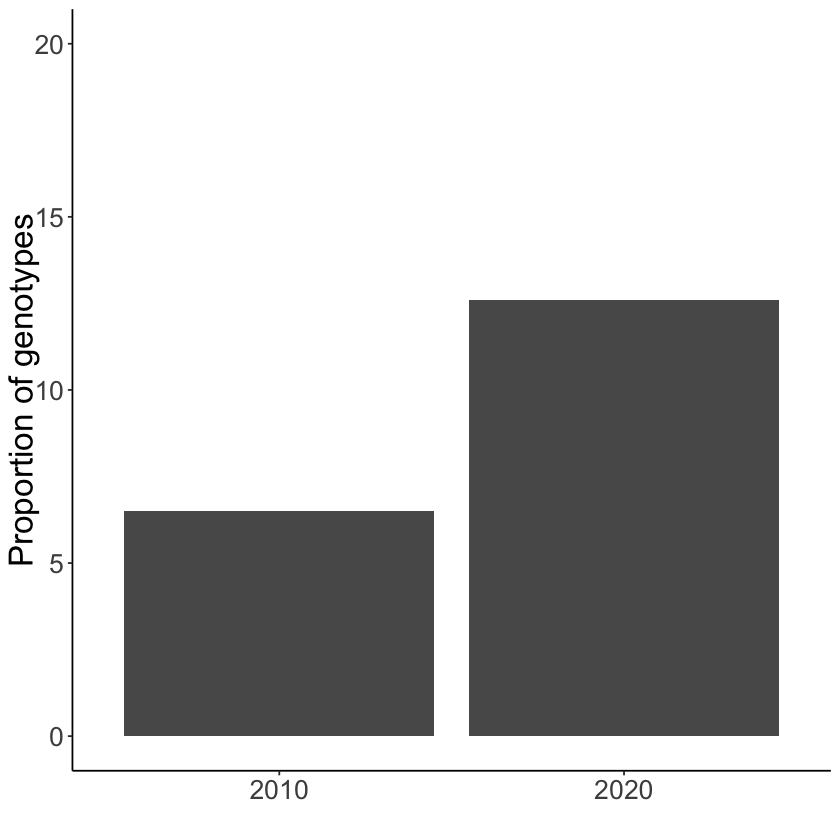

In [26]:
# Plot the data
df$Year <- factor(df$Year,levels=c("2010","2020"))
ggplot(df %>% filter(Group=="g2g-L2"), aes(x = Year, y = Percentage),color="red") +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
       x = "",
       y = "Proportion of genotypes") +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  ylim(0,20)
